![](https://i.ibb.co/Zm9Rmdb/lung-nb4-short.jpg)

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.5em; font-weight: 300;">SIIM COVID-19 EffNetV2 Keras Study Level Train [TPU]</span></p>

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Overview</span>

&nbsp;&nbsp;✅&nbsp;&nbsp;Training Official TF EfficientNetV2 Models on TPU [**CV AUC 0.804+**]<br>
&nbsp;&nbsp;✅&nbsp;&nbsp;Minimal Overhead TPU Augmentations<br>
&nbsp;&nbsp;✅&nbsp;&nbsp;Weights & Biases Integration<br>
<br>

**Please use v6 or above of this notebook, v4 or above of the TFHub Weight Files dataset and v6 or above of the inference notebook as some of the weight files are fixed.**

<br>

<p style='text-align: left;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.1em;"> 🏷️ Dataset with EffNetV2 TfHub Weights used in this notebook:</span></p>


>  [EfficientNetV2 TFHub Weight Files](https://www.kaggle.com/sreevishnudamodaran/efficientnetv2-tfhub-weight-files?select=tfhub_models)<br>
  Official EfficientNetV2 Saved Model Files from tfhub.dev

<br>

<p style='text-align: left;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.1em;"> 🏷️ Inference notebook for EffNetV2_L and Cascade RCNN:</span></p>

>[SIIM EffNetV2_L CascadeRCNN MMDetection Infer](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer)
<br>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.6em;">References:</span>

- https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
- https://www.kaggle.com/h053473666/siim-covid19-efnb7-train-study
- https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
- https://github.com/google/automl/blob/master/efficientnetv2

<br>
<span style="color: #000508; font-family: Segoe UI; font-size: 1.3em;">Related Notebooks:</span>

EfficientNetV2 with Fastai:
[SIIM Covid19 Fastai+EfficientNetV2+TIMM Models💠🏮](https://www.kaggle.com/sreevishnudamodaran/siim-covid19-fastai-efficientnetv2-timm-models)

<br>
<a href="https://www.kaggle.com/sreevishnudamodaran"><center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Ask%20me-something-1abc9c.svg?style=flat-square&logo=kaggle" width="130" height="10"></center></a>
<br>
<center><img border="0" alt="Ask Me Something" src="https://img.shields.io/badge/Please-Upvote%20If%20you%20like%20this-07b3c8?style=for-the-badge&logo=kaggle" width="260" height="20"></center>

In [1]:
import itertools
import os
import random
import gc
import numpy as np
import pandas as pd
import math
import pprint
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={"axes.titlesize":15, "axes.labelsize":9,"axes.titlepad":15,
            "axes.labelpad":12, "legend.fontsize":9,
            "legend.title_fontsize":9, "figure.titlesize":15,
            "axes.grid":False})

from sklearn.model_selection import train_test_split, GroupKFold
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets

print('TF version:', tf.__version__)
print('Hub version:', tfhub.__version__)
print('Physical devices:', tf.config.list_physical_devices())

TF version: 2.4.1
Hub version: 0.12.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Loaders & Augmentations on TPU</span>

Thanks to [@cdeotte](https://www.kaggle.com/cdeotte) & [@xhlulu](https://www.kaggle.com/xhlulu)

In [2]:
SATURATION  = (0.9, 1.1)
CONTRAST = (0.9, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 10.0
SHEAR    = 2.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 4.0
WSHIFT = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg.input_dims[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [3]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy


def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, path2, label, label2):
        u = tf.random.uniform([1], dtype='float32')
        p = tf.random.uniform([1], dtype='float32')
        if u > 0.5:
            img1 = tf.multiply(decode(path), p) 
            img2 = tf.multiply(decode(path2), 1-p) 
            numer = tf.add(img1, img2)
            denom = tf.math.sqrt(p**2 + (1-p)**2)
            img = numer/denom
#             img = (decode(path)* p + decode(path2) * (1-p))/(np.sqrt(p**2 + (1-p)**2))
            target = p * label + (1-p) * label2
        else:
            img = decode(path)
            target = label
        return img, target
    
    return decode_with_labels if with_labels else decode

def build_decoder_val(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, valid = None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,
                  seed=None, cache_dir=""):

    if labels is not None and valid is None:
        paths = np.repeat(paths, 3)
        labels = np.repeat(labels, 3, axis=0)

        directory = {'id': paths, 'Opacity': labels[:,0], 'None': labels[:,1]}
        angry = pd.DataFrame(directory).sample(len(paths))

        paths2 = angry['id'].values
        labels2 = angry[['Opacity', 'None']].values
        
#         u = np.random.uniform(0,1,len(paths)).astype(np.float32)
#         p = np.random.uniform(0,1,len(paths)).astype(np.float32)

    if decode_fn is None:
        decode_fn = build_decoder_val(labels is not None) if valid else build_decoder(labels is not None)
        
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

        
#     print(len(paths))
#     print(len(paths2))
    
    if valid is None:
#         slices = paths if labels is None else (paths, paths2, labels, labels2, u, p)
        slices = paths if labels is None else (paths, paths2, labels, labels2)
    else:
        slices = paths if labels is None else (paths, labels)
    
    AUTO = tf.data.experimental.AUTOTUNE    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)

    dset = dset.cache(cache_dir) if cache else dset
    
    # Map the functions to perform Augmentations
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle, seed=seed) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset
#     return slices

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">📥 EffNetV2 Architecture Selection</span>

<br>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Segoe UI, sans-serif;font-size:160px;
  overflow:hidden;padding:20px 15px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Segoe UI, sans-serif;font-size:160px;
  font-weight:normal;overflow:hidden;padding:20px 15px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:centre;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-0pky" style="font-size:16px;padding:5px 10px;text-align:center;font-family:Segoe UI;width:400px">Model Architecture</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b0</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b1</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b2</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-b3</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l-21k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-s-21k-ft1k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-m-21k-ft1k</td>
  </tr>
  <tr>
    <td class="tg-0pky" style="font-size:14px;padding:5px 10px;text-align:center;font-family:Segoe UI;">efficientnetv2-l-21k-ft1k</td>
  </tr>
</tbody>
</table>

<br>

<span style="font-family: Segoe UI; font-size: 1.2em;">📌 The model architectures with <b>no suffixes</b> are pretrained on ImageNet1K. The ones with the <b>'21k'</b> as the suffix are pretrained on ImageNet21K and the ones with <b>'21k-ft1k'</b> as the suffix are pretrained on ImageNet21K and then finetuned on ImageNet1K.</span>

<br>

 **ImageNet1K pretrained and finetuned models:**

|      ImageNet1K   |     Top1 Acc.  |    Params   |  FLOPs   | Inference Latency | links  |
|    ----------     |      ------    |    ------   | ------  | ------   |   ------   |
|    EffNetV2-S     |    83.9%   |    21.5M    |  8.4B    | [V100/A100](g3doc/effnetv2-s-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s.tgz),  [tensorboard](https://tensorboard.dev/experiment/wozwYcXkRPia76RopgCLlg)
|    EffNetV2-M     |    85.2%   |    54.1M    | 24.7B    | [V100/A100](g3doc/effnetv2-m-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m.tgz),  [tensorboard](https://tensorboard.dev/experiment/syoaqB2gTP6Vr0KRlrezmg)
|    EffNetV2-L     |    85.7%   |   119.5M    | 56.3B    | [V100/A100](g3doc/effnetv2-l-gpu.png) |  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l.tgz),  [tensorboard](https://tensorboard.dev/experiment/qgnTQ5JZQ92nSex6ZlWBbQ)

<br>

**Models Pretrained on ImageNet21K pretrained and finetuned with ImageNet1K:**


|  ImageNet21K  |  Pretrained models |  Finetuned ImageNet1K |
|  ----------   |  ------            |         ------       |
|  EffNetV2-S   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s-21k.tgz)  |  top1=84.9%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-s-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/7sga2olqTBeH4ioydel0hg/) |
|  EffNetV2-M   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m-21k.tgz)  |  top1=86.2%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-m-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/HkV6ANZSQ6WI5GhlZa48xQ/) |
|  EffNetV2-L   |  [pretrain ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l-21k.tgz)  |  top1=86.9%,  [ckpt](https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-l-21k-ft1k.tgz),  [tensorboard](https://tensorboard.dev/experiment/m9ZHx1L6SQu5iBYhXO5jOw/) |

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Global Config & Seeding</span>

In [4]:
def seed_everything(SEED):
    os.environ['PYTHONHASHSEED']=str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)

In [5]:
class Config:
    seed = 333
    job = 1
    num_classes = 2
    input_dims = (768, 768)
    model_arch = "efficientnetv2-l-21k-ft1k" ## Choose model architecture
    batch_size = 8*16
    kfold = 5
    n_epochs = 20
    lr = 0.0001
#     loss_func = 'categorical_crossentropy'
    loss_func = tf.keras.losses.KLDivergence()
    # Whether to finetune the whole model or just the top layer.
    fine_tune = True
    wandb_project = 'SIIM_classifier_public'
    dataset = "siim-covid19-images-metadata-256-512-768"
    
    seed_everything(seed)
    
cfg = Config()

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">KFold Split</span>

In [6]:
train_study = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")
train_image = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")

# Process id
train_image["image_id"] = train_image["id"].apply(lambda x: x.split("_")[0])
train_study["study_id"] = train_study["id"].apply(lambda x: x.split("_")[0])

# Merge all info together
train = pd.merge(train_image, train_study, 
                 left_on="StudyInstanceUID", right_on="study_id")

train.drop(["id_x", "id_y"], axis=1, inplace=True)

# duplicate none value drop
train=train[~(train['study_id'].eq(train['study_id'].shift(-1)) & train['boxes'].isnull())]
train=train[~(train['study_id'].eq(train['study_id'].shift(1)) & train['boxes'].isnull())]
train.reset_index(inplace=True, drop=True)

train

boxes  \
0     [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1                                                   NaN   
2     [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                                                 ...   
6049                                                NaN   
6050                                                NaN   
6051  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6052  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6053  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label StudyInstanceUID  \
0     opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                        none 1 0 0 1 1     ff0879eb20ed   
2     opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3       opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4     opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   
...                                                 ...              ...   
6049                                     none 1 0 0 1 1     7e6c68462e06   
6050                                     none 1 0 0 1 1     8332bdaddb6e   
6051  opacity 1 2197.38566 841.07361 2513.80265 1292...     7eed9af03814   
6052  opacity 1 2729.27083 332.26044 4225.52099 2936...     a0cb0b96fb3d   
6053  opacity 1 208.86463 91.53448 659.8321 719.5892...     7d82d53204b8   

          image_id  Negative for Pneumonia  Typical Appearance  \
0     000a312787f2                       0                   1   
1     000c3a3f293f                       1                   0   
2     0012ff7358bc                       0                   1   
3     001398f4ff4f                       0                   0   
4     001bd15d1891                       0                   1   
...            ...                     ...                 ...   
6049  ffcc6edd9445                       1                   0   
6050  ffd91a2c4ca0                       1                   0   
6051  ffd9b6cf2961                       0                   1   
6052  ffdc682f7680                       0                   1   
6053  ffe942c8655f                       0                   1   

      Indeterminate Appearance  Atypical Appearance      study_id  
0                            0                    0  5776db0cec75  
1                            0                    0  ff0879eb20ed  
2                            0                    0  9d514ce429a7  
3                            0                    1  28dddc8559b2  
4                            0                    0  dfd9fdd85a3e  
...                        ...                  ...           ...  
6049                         0                    0  7e6c68462e06  
6050                         0                    0  8332bdaddb6e  
6051                         0                    0  7eed9af03814  
6052                         0                    0  a0cb0b96fb3d  
6053                         0                    0  7d82d53204b8  

[6054 rows x 9 columns]

In [7]:
def label_create(data):
    ConditionList = [
    (train['Negative for Pneumonia'] == 1),
    (train['Typical Appearance'] == 1),
    (train['Indeterminate Appearance'] == 1),
    (train['Atypical Appearance']==1)
]
    ChoiceList = ['Negative','Typical','Indeterminate','Atypical']

    data.insert(2,'label name' ,np.select(ConditionList,ChoiceList, default = 'Negative'))
    
    df = []
    for i in range(data.shape[0]):
        if data.loc[i,'label'].split(' ')[0] == 'opacity':
            label = data.loc[i,'label'].replace('opacity', np.select(ConditionList,ChoiceList, default = 'Negative')[i])
            df.append(label)
        else:
            label = data.loc[i,'label'].replace('none', np.select(ConditionList,ChoiceList, default = 'Negative')[i])
            df.append(label)
    df = pd.Series(df)
    data['label'] = df
#    data.drop(labels='label name',axis=1,inplace=True)
    data.insert(5,'none',0)
    train.loc[train[train['boxes'].isnull()].index.values,'none'] = 1
    data.drop(train.columns[-1],axis=1, inplace=True)
    return data

image_df = label_create(train)
image_df['image_id'] = image_df['image_id'] + '_image'
image_df

boxes  \
0     [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1                                                   NaN   
2     [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3     [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4     [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   
...                                                 ...   
6049                                                NaN   
6050                                                NaN   
6051  [{'x': 2197.38566, 'y': 841.07361, 'width': 31...   
6052  [{'x': 2729.27083, 'y': 332.26044, 'width': 14...   
6053  [{'x': 208.86463, 'y': 91.53448, 'width': 450....   

                                                  label label name  \
0     Typical 1 789.28836 582.43035 1815.94498 2499....    Typical   
1                                    Negative 1 0 0 1 1   Negative   
2     Typical 1 677.42216 197.97662 1545.21983 1197....    Typical   
3      Atypical 1 2729 2181.33331 3677.00012 2785.33331   Atypical   
4     Typical 1 623.23328 1050 1337.23328 2156 Typic...    Typical   
...                                                 ...        ...   
6049                                 Negative 1 0 0 1 1   Negative   
6050                                 Negative 1 0 0 1 1   Negative   
6051  Typical 1 2197.38566 841.07361 2513.80265 1292...    Typical   
6052  Typical 1 2729.27083 332.26044 4225.52099 2936...    Typical   
6053  Typical 1 208.86463 91.53448 659.8321 719.5892...    Typical   

     StudyInstanceUID            image_id  none  Negative for Pneumonia  \
0        5776db0cec75  000a312787f2_image     0                       0   
1        ff0879eb20ed  000c3a3f293f_image     1                       1   
2        9d514ce429a7  0012ff7358bc_image     0                       0   
3        28dddc8559b2  001398f4ff4f_image     0                       0   
4        dfd9fdd85a3e  001bd15d1891_image     0                       0   
...               ...                 ...   ...                     ...   
6049     7e6c68462e06  ffcc6edd9445_image     1                       1   
6050     8332bdaddb6e  ffd91a2c4ca0_image     1                       1   
6051     7eed9af03814  ffd9b6cf2961_image     0                       0   
6052     a0cb0b96fb3d  ffdc682f7680_image     0                       0   
6053     7d82d53204b8  ffe942c8655f_image     0                       0   

      Typical Appearance  Indeterminate Appearance  Atypical Appearance  
0                      1                         0                    0  
1                      0                         0                    0  
2                      1                         0                    0  
3                      0                         0                    1  
4                      1                         0                    0  
...                  ...                       ...                  ...  
6049                   0                         0                    0  
6050                   0                         0                    0  
6051                   1                         0                    0  
6052                   1                         0                    0  
6053                   1                         0                    0  

[6054 rows x 10 columns]

In [8]:

df = pd.read_csv('../input/siim-covid19-images-metadata-256-512-768/images_metadata_256_512_768/train_meta_768x768.csv')
# image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
# image_df
df = pd.merge(df, image_df, left_on = 'id',right_on = 'image_id' ,how = 'right')


gkf  = GroupKFold(n_splits=cfg.kfold)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df.study_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
    
# df.to_csv('image_train_df.csv')
df.drop(['StudyInstanceUID','image_id'],axis=1,inplace=True)
df


gkf  = GroupKFold(n_splits=cfg.kfold)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df.study_id.tolist())):
    df.loc[val_idx, 'fold'] = fold

    
df = df.reset_index()
# df.to_csv('study_train_df.csv')
df.sample(3)


index                  id     folder_id      study_id  width  height  \
2460   2460  65bd2ff1f2a1_image  d98e0facf4fe  3ca4e2ffedff   2832    2320   
3509   3509  91991f8b449f_image  f303bcd97b6e  384d1d316992   2836    2336   
5292   5292  dd7805f39e0d_image  4c9e225341e0  d97dffd12359   3408    3164   

                                                  boxes  \
2460  [{'x': 221.25, 'y': 1393.2344, 'width': 837.06...   
3509                                                NaN   
5292                                                NaN   

                                                  label label name  none  \
2460  Typical 1 221.25 1393.2344 1058.3125 2268.375 ...    Typical     0   
3509                                 Negative 1 0 0 1 1   Negative     1   
5292                                 Negative 1 0 0 1 1   Negative     1   

      Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
2460                       0                   1                         0   
3509                       1                   0                         0   
5292                       1                   0                         0   

      Atypical Appearance  fold  
2460                    0     1  
3509                    0     2  
5292                    0     0

In [9]:
# # label_cols = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
# # df[df['fold']==fold][label_cols].values

# directory = {'id': train_paths, 'Negative for Pneumonia': train_labels[:,0], 'Typical Appearance': train_labels[:,1], 
#             'Indeterminate Appearance': train_labels[:,2], 'Atypical Appearance': train_labels[:,3]}
# angry = pd.DataFrame(directory).sample(len(train_paths))

# paths2 = angry['id'].values
# labels2 = angry[['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']].values
# print(labels2)
# print(train_labels)

In [10]:
# GCS_DS_PATH = KaggleDatasets().get_gcs_path(cfg.dataset)
# label_cols = 'none'

# valid_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']==fold]['id'] + '.png' #"/train/"
# train_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']!=fold]['id'] + '.png' #"/train/" 
# valid_labels = df[df['fold']==fold][label_cols].values
# train_labels = df[df['fold']!=fold][label_cols].values
# print(train_labels)

# num = np.unique(train_labels, axis=0)
# num = num.shape[0]

# train_labels = np.eye(num)[train_labels]
# train_labels = train_labels.astype(np.float32)
# print(train_labels)

# num = np.unique(valid_labels, axis=0)
# num = num.shape[0]

# valid_labels = np.eye(num)[valid_labels]
# valid_labels = valid_labels.astype(np.float32)

In [11]:
# decoder = build_decoder(with_labels=True, target_size=cfg.input_dims, ext='png')
# test_decoder = build_decoder(with_labels=False, target_size=cfg.input_dims, ext='png')

# train_dataset = build_dataset(
#     train_paths, train_labels, bsize=cfg.batch_size, decode_fn=decoder
# )
# print(cfg.batch_size)

<span style="color: #027fc1; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">🚀 Training</span>

We first find the GCS path of the selected EffNetV2 architecture from the EffNetV2 weights Kaggle dataset.

In [12]:
# Get the TensorFlow Hub model URL
hub_type = 'feature_vector' # ['classification', 'feature_vector']
# Get the GCS path of EfficientNet Models
DS_GCS_PATH = KaggleDatasets().get_gcs_path("efficientnetv2-tfhub-weight-files")
MODEL_GCS_PATH = f'{DS_GCS_PATH}/tfhub_models/{cfg.model_arch}/{hub_type}'
MODEL_GCS_PATH

'gs://kds-79d12035a9312909e41e9d13db7b3fe9a9d32efc3ac39f54d3373c1f/tfhub_models/efficientnetv2-l-21k-ft1k/feature_vector'

In [13]:
label_cols = 'none'
# label_cols = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.7em; font-weight: 300;">HAVE A GREAT DAY!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.3em; font-weight: 300;">Let me know if you have any suggestions!</span></p>


Fold: 0
Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas
Train Job: efficientnetv2-l-21k-ft1k_fold0_job1 
Config
{'batch_size': 128,
 'dataset': 'siim-covid19-images-metadata-256-512-768',
 'fine_tune': 'True',
 'fold': 0,
 'input_dims': '(768, 768)',
 'job': 1,
 'job_name': 'efficientnetv2-l-21k-ft1k_fold0_job1',
 'kfold': 5,
 'loss_func': '<tensorflow.python.keras.losses.KLDivergence object at '
              '0x7f90af4b0550>',
 'lr': '0.0001',
 'model_arch': 'efficientnetv2-l-21k-ft1k',
 'n_epochs': 20,
 'num_classes': 2,
 'seed': 333,
 'wandb_project': 'SIIM_classifier_public'}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              117746848 
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
__________________________________________________

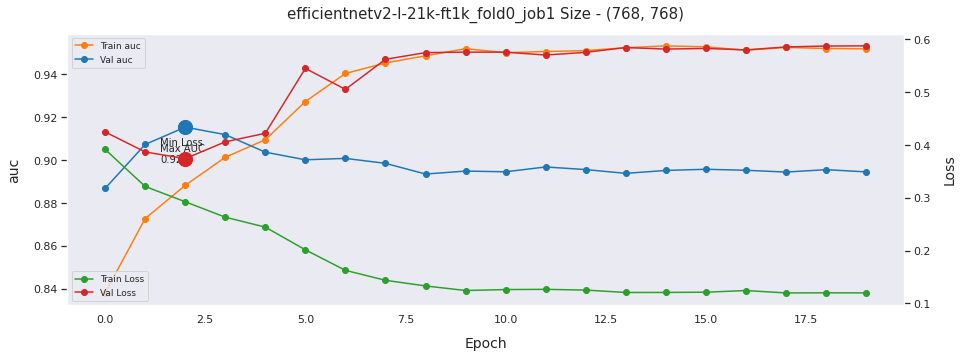


----------------------------------------
CV AUC: 0.18305479288101195
----------------------------------------


In [14]:
DISPLAY_PLOT = True
oof_aucs = dict()

# Get the GCS path of the images from the Kaggle dataset
GCS_DS_PATH = KaggleDatasets().get_gcs_path(cfg.dataset)
for fold in range(0, 1):
    
    print("\nFold:", fold)
    
    # Define TPU strategy and clear TPU
    strategy = auto_select_accelerator()
    
    # Converting global config class object to a dictionary to log using Wandb
    config_dict = dict(vars(Config))
    config_dict = {k:(v if type(v)==int else str(v)) for (k,v) in config_dict.items() if '__' not in k}
    config_dict['fold'] = fold
    config_dict['job_name'] = f"{config_dict['model_arch']}_fold{fold}_job{config_dict['job']}"
    print("Train Job:", config_dict['job_name'], "\nConfig")
    pprint.pprint(config_dict)

#     wandb.init(project=cfg.wandb_project, name=config_dict['job_name'], config=config_dict)

    valid_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']==fold]['id'] + '.png' #"/train/"
    train_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']!=fold]['id'] + '.png' #"/train/" 
    valid_labels = df[df['fold']==fold][label_cols].values
    train_labels = df[df['fold']!=fold][label_cols].values
#     valid_labels = valid_labels.astype(np.float32)
#     train_labels = train_labels.astype(np.float32)
    
    num = np.unique(train_labels, axis=0)
    num = num.shape[0]

    train_labels = np.eye(num)[train_labels]
    train_labels = train_labels.astype(np.float32)

    num = np.unique(valid_labels, axis=0)
    num = num.shape[0]

    valid_labels = np.eye(num)[valid_labels]
    valid_labels = valid_labels.astype(np.float32)

    decoder = build_decoder(with_labels=True, target_size=cfg.input_dims, ext='png')
    val_decoder = build_decoder_val(with_labels=True, target_size=cfg.input_dims, ext='png')
    test_decoder = build_decoder_val(with_labels=False, target_size=cfg.input_dims, ext='png')

    train_dataset = build_dataset(
        train_paths, train_labels, valid = None, bsize=cfg.batch_size, decode_fn=decoder
    )

    valid_dataset = build_dataset(
        valid_paths, valid_labels, valid = True, bsize=cfg.batch_size, decode_fn=val_decoder,
        repeat=False, shuffle=False, augment=False
    )

    num_classes = cfg.num_classes if cfg.num_classes else train_labels.shape[1]

    with strategy.scope():
        model = tf.keras.Sequential([
            # Explicitly define the input shape so the model can be properly
            # loaded by the TFLiteConverter
            tf.keras.layers.InputLayer(input_shape=[cfg.input_dims[0], cfg.input_dims[1], 3]),
            tfhub.KerasLayer(MODEL_GCS_PATH, trainable=cfg.fine_tune),
            tf.keras.layers.Dropout(rate=0.1),
            tf.keras.layers.Dense(num_classes,
                                  activation='softmax')
        ])

        model.build((None, cfg.input_dims[0], cfg.input_dims[1], 3))
        model.summary()

        metrics = ['accuracy', tf.keras.metrics.AUC(name='auc', multi_label=False)]
        model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.lr),
          loss=cfg.loss_func,
          metrics=metrics)

    steps_per_epoch = train_paths.shape[0] // cfg.batch_size * 3
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f'model{fold}.h5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min'),
#         wandb.keras.WandbCallback(save_model=True,
#                       monitor='val_loss',
#                       mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                             patience=3,
                                             min_lr=1e-6,
                                             mode='min'),
                ]

    history = model.fit(
        train_dataset, 
        epochs=cfg.n_epochs,
        verbose=1,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset)

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history{fold}.csv')

#    del decoder, test_decoder, train_dataset, valid_dataset, model
    gc.collect()

    oof_aucs[fold] = float(np.max(history.history['val_auc']))
    print("oof_aucs", oof_aucs)
    
#     wandb.finish()
    
    # Plot Training History
    if DISPLAY_PLOT:
        print ("\n\n")
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(history.history['auc'])), history.history['auc'],
                 '-o', label='Train auc', color='#ff7f0e')
        plt.plot(np.arange(len(history.history['auc'])), history.history['val_auc'],
                 '-o', label='Val auc', color='#1f77b4')
        x = np.argmax(history.history['val_auc'])
        y = np.max(history.history['val_auc'])
        xdist = plt.xlim()[1] - plt.xlim()[0]
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200, color='#1f77b4')
        plt.text(x-0.03*xdist, y-0.13*ydist, 'Max AUC\n%.2f'%y, size=10)
        plt.ylabel('auc', size=14)
        plt.xlabel('Epoch', size=14)
        plt.legend(loc=2)

        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['loss'],'-o', label='Train Loss', color='#2ca02c')
        plt2.plot(np.arange(len(history.history['auc'])),
                  history.history['val_loss'],'-o', label='Val Loss', color='#d62728')
        x = np.argmin(history.history['val_loss'])
        y = np.min(history.history['val_loss'])
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x, y, s=200, color='#d62728')
        plt.text(x-0.03*xdist, y+0.05*ydist,'Min Loss', size=10)
        plt.ylabel('Loss', size=14)
        plt.title(f"{config_dict['job_name']} Size - {cfg.input_dims}")
        plt.legend(loc=3)
        plt.savefig(f'fig{fold}.png')
        plt.show()
        
print("\n"+"-"*40)
print("CV AUC:", sum(list(oof_aucs.values()))/cfg.kfold)
print("-"*40)

In [15]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# y_pred = model.predict(next(iter(valid_dataset)))
# prediction = [1 if y_pred[i] > 0.5 else 0 for i in range(len(y_pred))]


In [16]:
val_imgs, val_outs = next(iter(valid_dataset))
y_pred = model.predict(val_imgs)

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


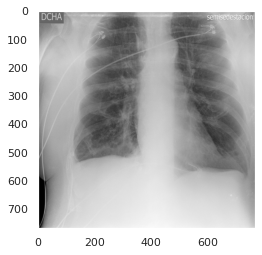

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


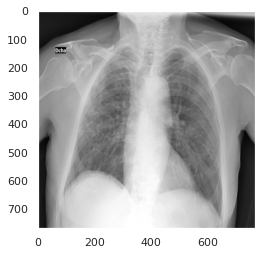

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


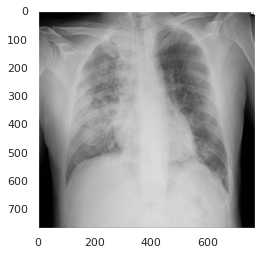

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


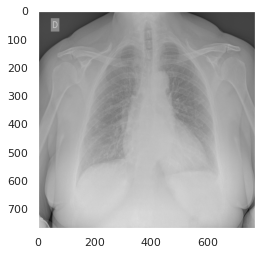

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


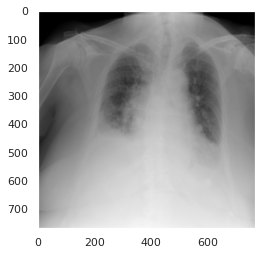

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


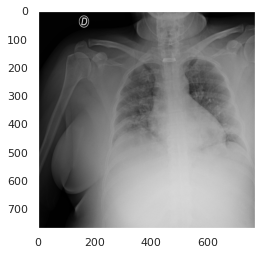

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


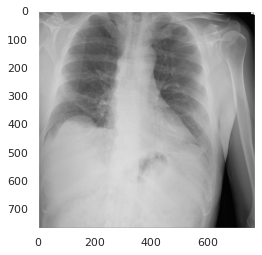

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


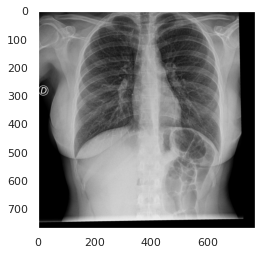

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


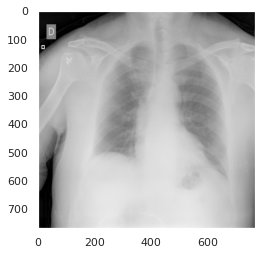

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


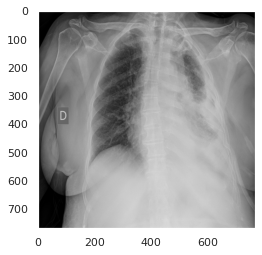

In [17]:
for i in range(10):
    print(val_outs[i])
    plt.imshow(val_imgs[i])
    plt.show()

In [18]:
imgs, outs = next(iter(train_dataset))

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


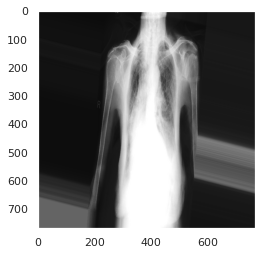

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


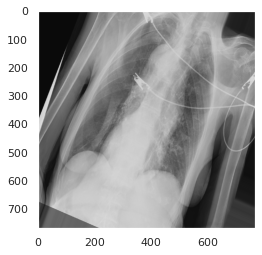

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


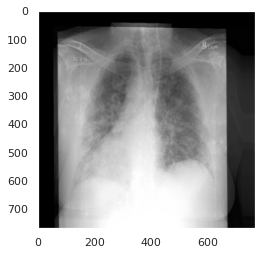

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


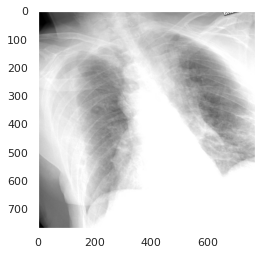

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


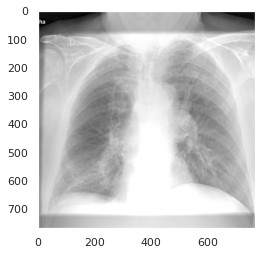

tf.Tensor([0.89976215 0.10023785], shape=(2,), dtype=float32)


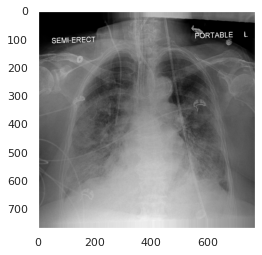

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


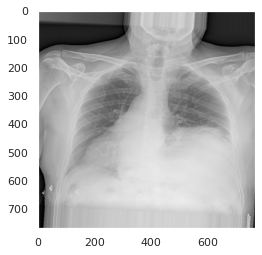

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


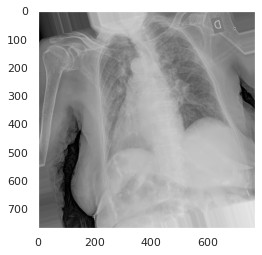

tf.Tensor([0.19692242 0.8030776 ], shape=(2,), dtype=float32)


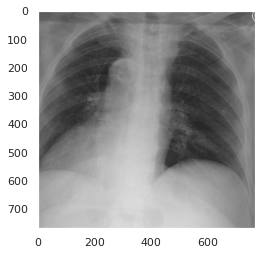

tf.Tensor([0.81004965 0.18995035], shape=(2,), dtype=float32)


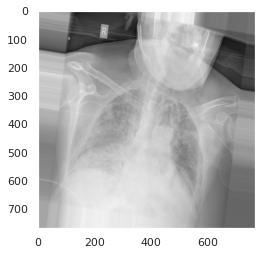

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


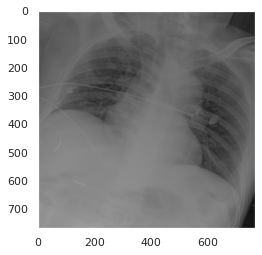

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


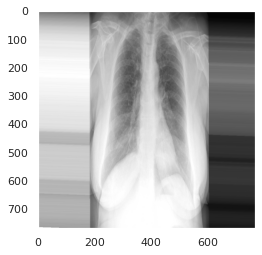

tf.Tensor([0.44804418 0.5519558 ], shape=(2,), dtype=float32)


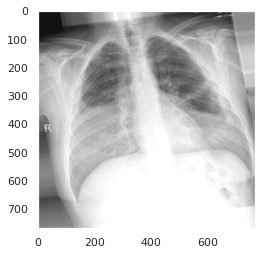

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


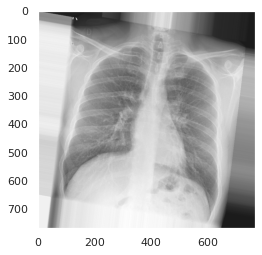

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


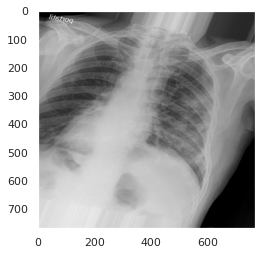

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


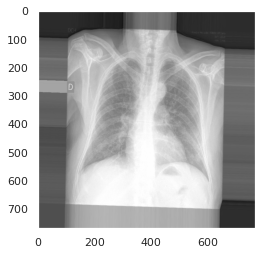

tf.Tensor([0.61889446 0.38110554], shape=(2,), dtype=float32)


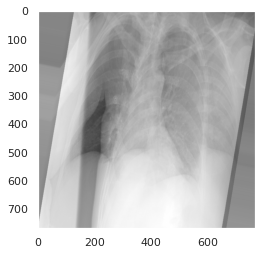

tf.Tensor([0.07030499 0.929695  ], shape=(2,), dtype=float32)


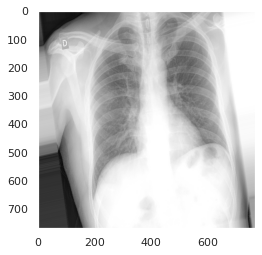

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


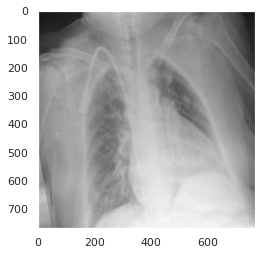

tf.Tensor([0.5575286  0.44247139], shape=(2,), dtype=float32)


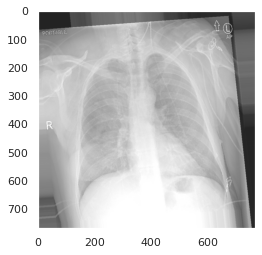

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


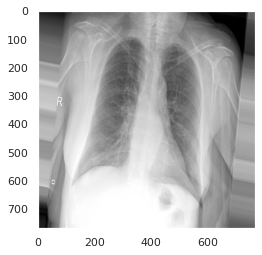

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


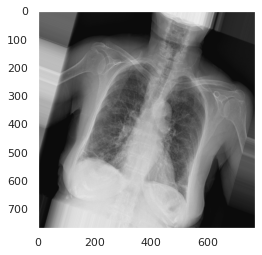

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


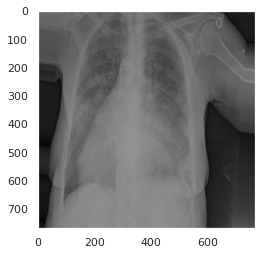

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


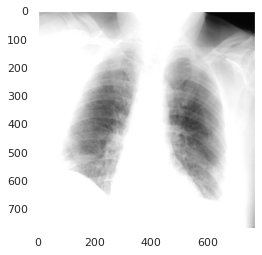

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


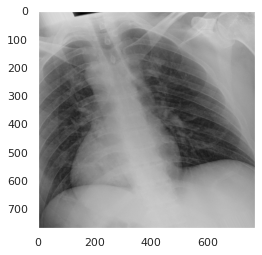

tf.Tensor([0.18381035 0.81618965], shape=(2,), dtype=float32)


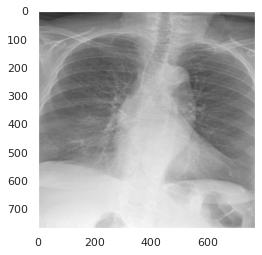

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


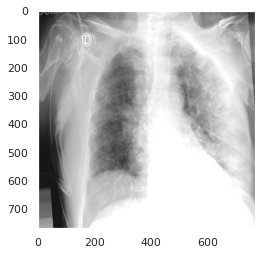

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


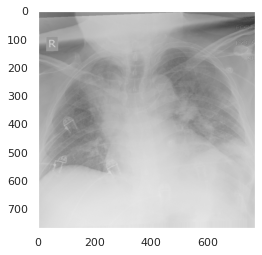

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


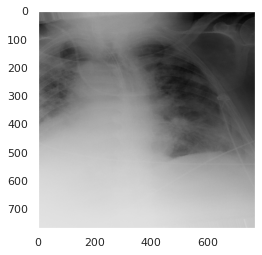

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


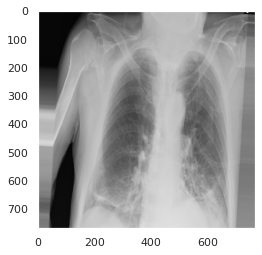

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


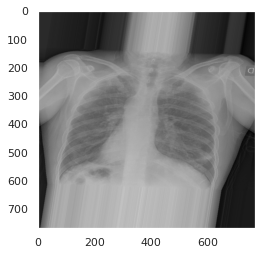

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


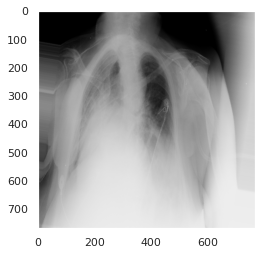

tf.Tensor([0.02381778 0.9761822 ], shape=(2,), dtype=float32)


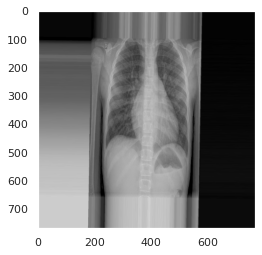

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


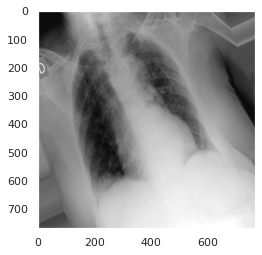

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


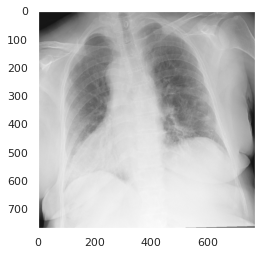

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


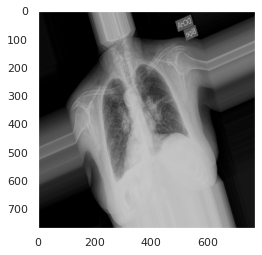

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


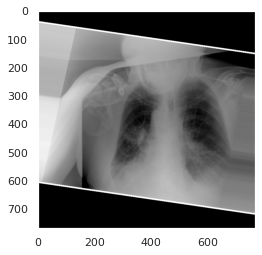

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


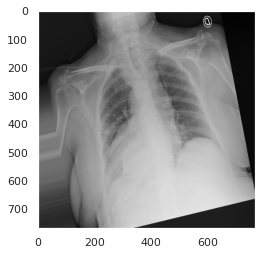

tf.Tensor([0.63306034 0.36693966], shape=(2,), dtype=float32)


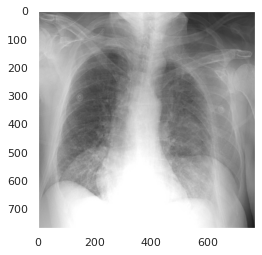

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


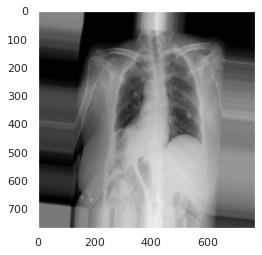

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


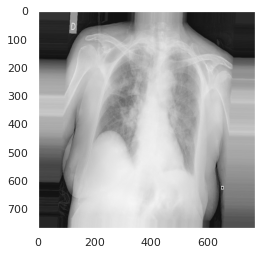

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


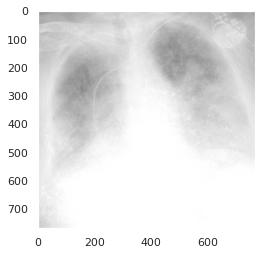

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


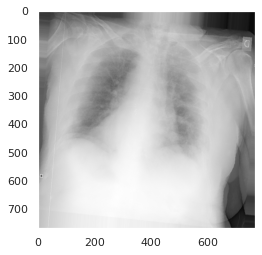

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


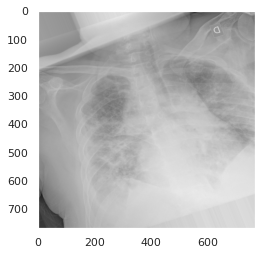

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


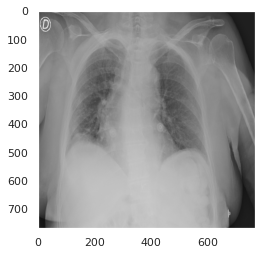

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


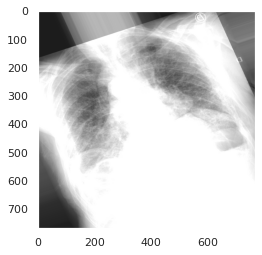

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


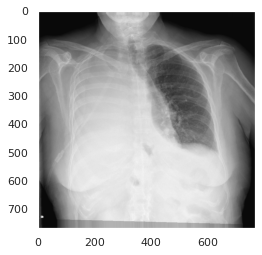

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


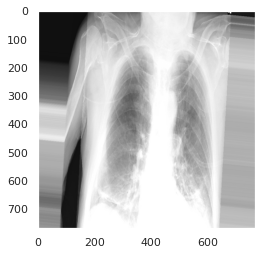

tf.Tensor([0.21081829 0.7891817 ], shape=(2,), dtype=float32)


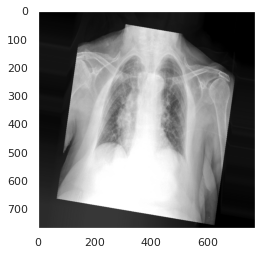

tf.Tensor([0.8485223 0.1514777], shape=(2,), dtype=float32)


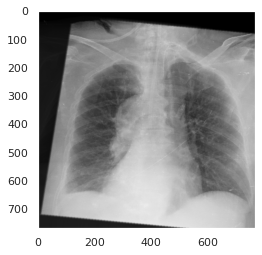

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


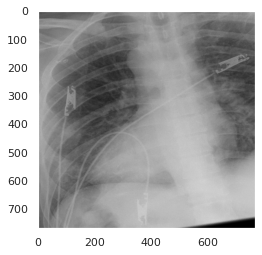

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


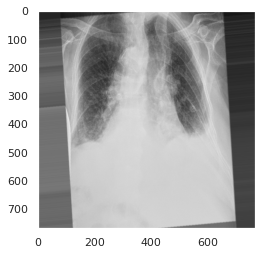

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


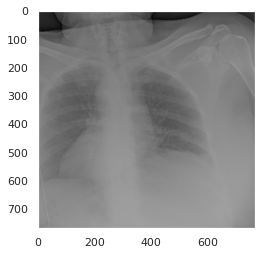

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


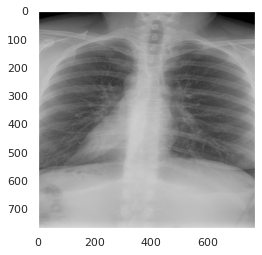

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


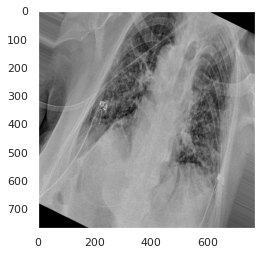

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


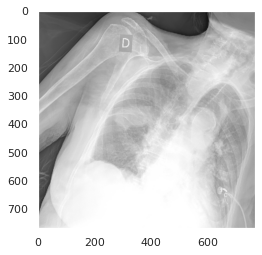

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


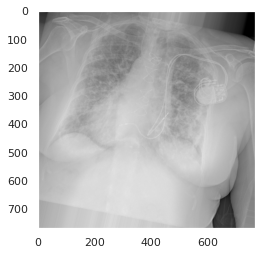

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


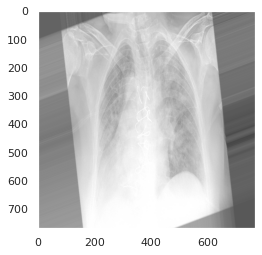

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


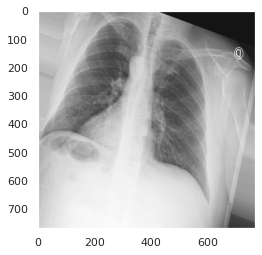

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


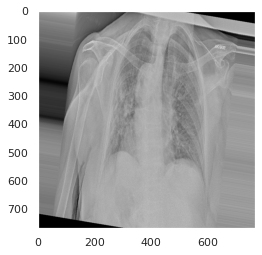

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


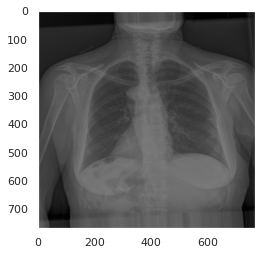

tf.Tensor([0.21452343 0.78547657], shape=(2,), dtype=float32)


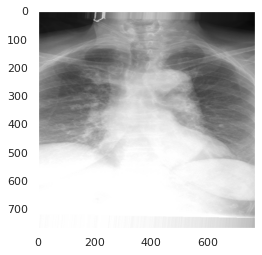

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


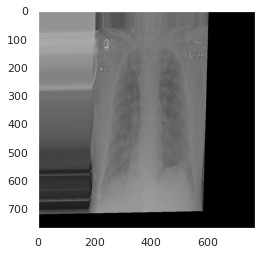

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


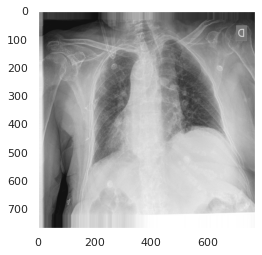

tf.Tensor([0.2942568 0.7057432], shape=(2,), dtype=float32)


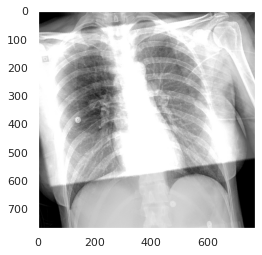

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


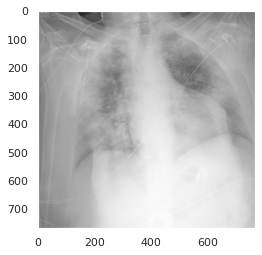

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


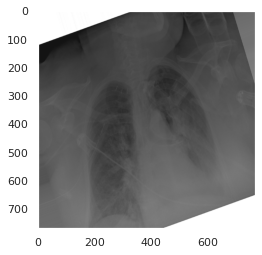

tf.Tensor([0.5402107  0.45978928], shape=(2,), dtype=float32)


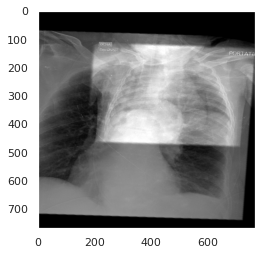

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


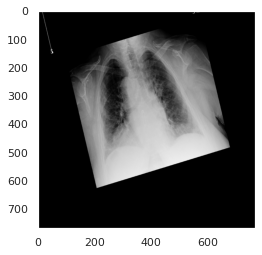

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


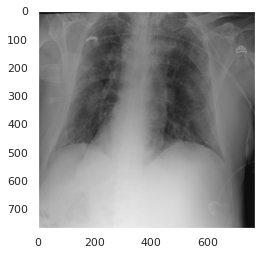

tf.Tensor([0.46295154 0.53704846], shape=(2,), dtype=float32)


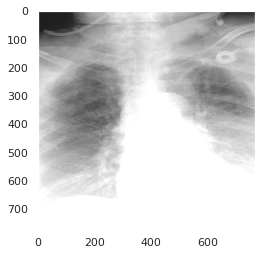

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


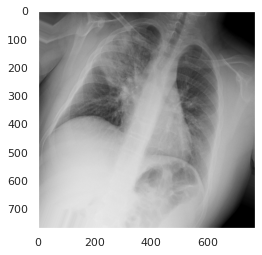

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


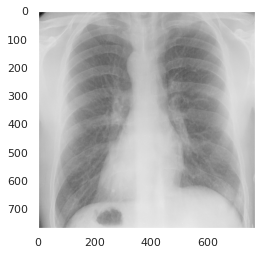

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


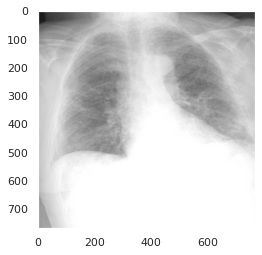

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


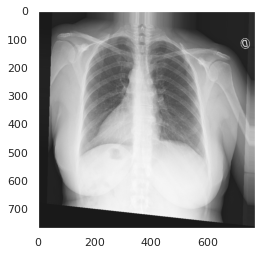

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


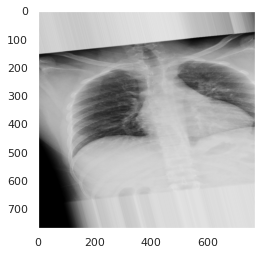

tf.Tensor([0.09775257 0.9022474 ], shape=(2,), dtype=float32)


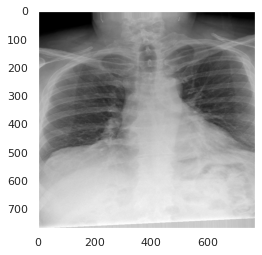

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


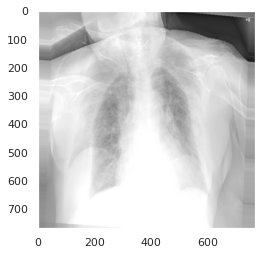

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


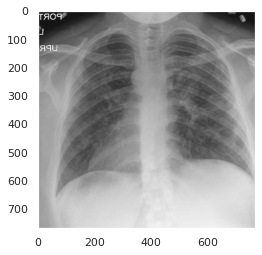

tf.Tensor([0.69366133 0.30633867], shape=(2,), dtype=float32)


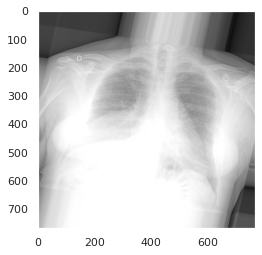

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


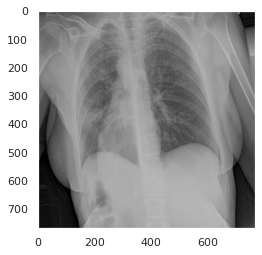

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


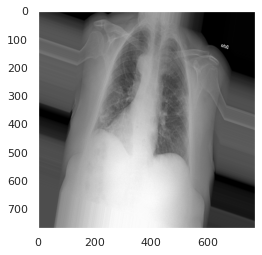

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


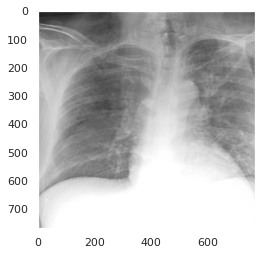

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


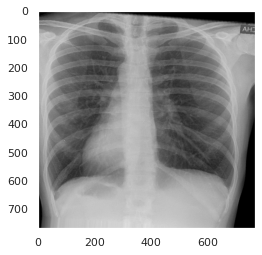

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


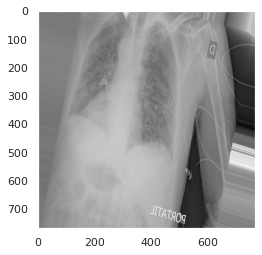

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


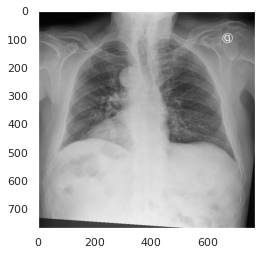

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


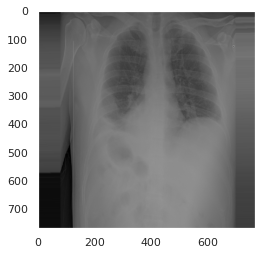

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


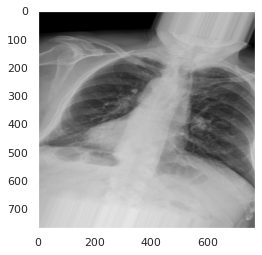

tf.Tensor([0.46556687 0.5344331 ], shape=(2,), dtype=float32)


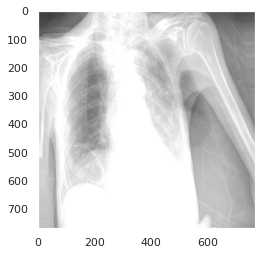

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


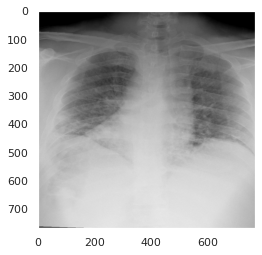

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


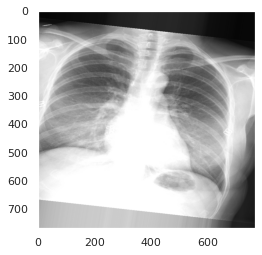

tf.Tensor([0.24454427 0.75545573], shape=(2,), dtype=float32)


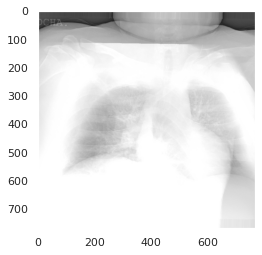

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


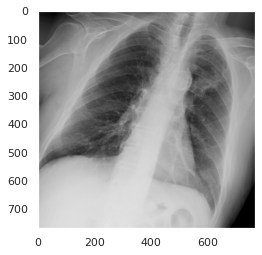

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


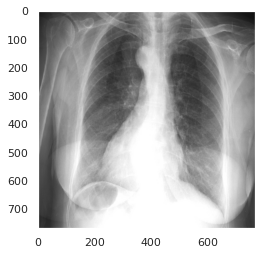

tf.Tensor([0.22634804 0.77365196], shape=(2,), dtype=float32)


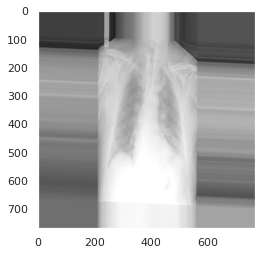

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


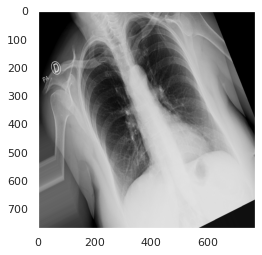

tf.Tensor([0. 1.], shape=(2,), dtype=float32)


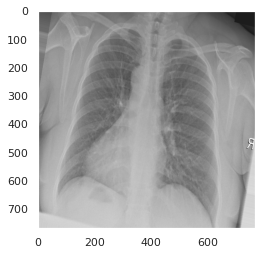

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


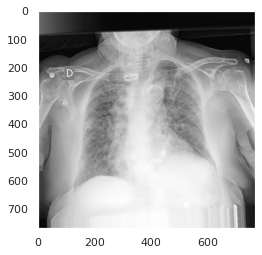

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


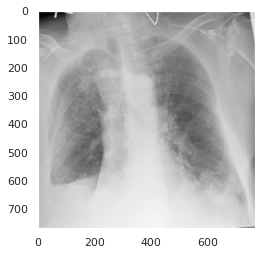

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


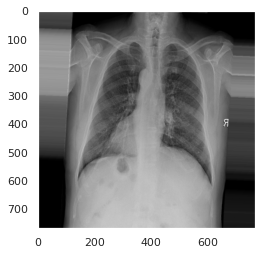

In [19]:
for i in range(100):
    print(outs[i])
    plt.imshow(imgs[i])
    plt.show()

In [20]:
print(outs[0])

tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [21]:
prediction = np.argmax(y_pred,axis=1)
prediction

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [22]:
valid_out = np.argmax(val_outs,axis=1)
valid_out

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [23]:
precision, recall, fscore, support = score(prediction,valid_out)

In [24]:
confusion_matrix(valid_out, prediction)

array([[73, 11],
       [12, 32]])

In [25]:
precision

array([0.86904762, 0.72727273])

In [26]:
recall

array([0.85882353, 0.74418605])

In [27]:
fscore

array([0.86390533, 0.73563218])

In [28]:
accuracy_score(prediction,valid_out)

0.8203125

In [29]:
valid_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']==fold]['id'] + '.png' #"/train/"
train_paths = GCS_DS_PATH + '/images_metadata_256_512_768/train_768x768/' + df[df['fold']!=fold]['id'] + '.png' #"/train/" 
df[df['fold']==fold][label_cols].value_counts()



0    836
1    375
Name: none, dtype: int64

In [30]:
# import os
# os.chdir(r'/kaggle/working')

In [31]:
# from IPython.display import FileLink
# FileLink(r'model2.h5')